# 1. Setup

Import librarys and load database into juypiter

### Connect to data base

In [1]:
!pip install geoalchemy2
!pip install matplotlib

In [2]:
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd
import geopandas as gpd
from datetime import datetime
from sqlalchemy import text
from sqlalchemy import inspect
from sqlalchemy import create_engine
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="sydney"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn
    
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

srid = 4283

In [3]:
db, conn = pgconnect(credentials)

Connected successfully.


### Import data into python and data cleaning

Loading all datasets into python first using **Geopandas** module. 

Removed any empty primary keys, transformed geospatial into formats recognizable by SQL, and renamed some of the columns.

Differences between polygons and multipolygons: https://gis.stackexchange.com/questions/225368/understanding-difference-between-polygon-and-multipolygon-for-shapefiles-in-qgis 

Some are polygons and some are multi, if we make them all multipolygons...

In [4]:
SA2_Regions = gpd.read_file('SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
# SA2_shapely = SA2_Regions
SA2_Regions = SA2_Regions[SA2_Regions['GCC_CODE21'] == "1GSYD"]

def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    elif geom.geom_type == 'Point':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)
SA2_Regionsog = SA2_Regions.copy() 
SA2_regions_geometry = SA2_Regions
SA2_Regions['geom'] = SA2_Regions['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) 
SA2_Regions.columns = map(str.lower, SA2_Regions.columns)
SA2_Regions

,sa2_code21,sa2_name21,chg_flag21,chg_lbl21,sa3_code21,sa3_name21,sa4_code21,sa4_name21,gcc_code21,gcc_name21,ste_code21,ste_name21,aus_code21,aus_name21,areasqkm21,loci_uri21,geometry,geom
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4...",MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5...",MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4...",MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4...",MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.07363 -34.05638, 151.07360 -34.0...",MULTIPOLYGON (((151.07362997413264 -34.0563789...
638,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.05006 -34.02158, 151.05008 -34.0...",MULTIPOLYGON (((151.05006441218998 -34.0215774...
639,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((150.99568 -34.05361, 150.99570 -34.0...",MULTIPOLYGON (((150.99568346574816 -34.0536082...
640,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.03955 -34.04175, 151.03954 -34.0...",MULTIPOLYGON (((151.03954821100714 -34.0417452...


Removing unwanted columns. Note we can only run this once. (Running any ***drop column functions twice*** will result in an **error**)

In [5]:
SA2_Regions = SA2_Regions.drop(columns=['geometry', 'gcc_code21', 'gcc_name21', 'ste_code21', 'ste_name21', 'aus_code21', 'aus_name21'])
SA2_Regions.head(10)

,sa2_code21,sa2_name21,chg_flag21,chg_lbl21,sa3_code21,sa3_name21,sa4_code21,sa4_name21,areasqkm21,loci_uri21,geom
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.32348639265098 -33.4277852...
33,102011033,Kariong,0,No change,10201,Gosford,102,Central Coast,8.3063,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.2856983473498 -33.43233822...
34,102011034,Kincumber - Picketts Valley,0,No change,10201,Gosford,102,Central Coast,11.7169,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37292545042803 -33.4672773...
35,102011035,Narara,0,No change,10201,Gosford,102,Central Coast,7.7021,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.32173446737218 -33.3942363...
36,102011036,Niagara Park - Lisarow,0,No change,10201,Gosford,102,Central Coast,16.7316,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.34438983583274 -33.3819733...
37,102011037,Point Clare - Koolewong,0,No change,10201,Gosford,102,Central Coast,6.7794,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.3084624827523 -33.44283732...


Businesses dataset:

In SQL column names cannot start with numbers 

check if any row is empty, set `sa2_code` as primary key.

In [6]:
businesses = pd.read_csv('Businesses.csv')

column_mapping = {
    '0_to_50k_businesses': 'businesses_0_50k',
    '50k_to_200k_businesses': 'businesses_50k_200k',
    '200k_to_2m_businesses': 'businesses_200k_2m',
    '2m_to_5m_businesses': 'businesses_2m_5m',
    '5m_to_10m_businesses': 'businesses_5m_10m',
    '10m_or_more_businesses': 'businesses_10m_or_more',
    'total_businesses': 'total_businesses'
}
businesses.rename(columns=column_mapping, inplace=True)

# Check for missing values in the 'sa2_code' column, as this is the primary key
missing_sa2_code = businesses['sa2_code'].isnull()
print (f"{businesses['sa2_code'].isnull().sum()} rows with empty primary key have been deleted")
businesses = businesses[~missing_sa2_code]
businesses.columns = map(str.lower, businesses.columns)

businesses.head(20)




0 rows with empty primary key have been deleted


,industry_code,industry_name,sa2_code,sa2_name,businesses_0_50k,businesses_50k_200k,businesses_200k_2m,businesses_2m_5m,businesses_5m_10m,businesses_10m_or_more,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
5,A,"Agriculture, Forestry and Fishing",101021610,Googong,0,3,0,0,0,0,3
6,A,"Agriculture, Forestry and Fishing",101021611,Queanbeyan Surrounds,182,80,60,5,0,0,327
7,A,"Agriculture, Forestry and Fishing",101031013,Bombala,65,92,81,6,0,0,246
8,A,"Agriculture, Forestry and Fishing",101031014,Cooma,28,30,36,3,0,3,96
9,A,"Agriculture, Forestry and Fishing",101031015,Cooma Surrounds,91,84,73,0,0,0,251


A summary of our data so far

In [7]:
businesses.dtypes

industry_code             object
industry_name             object
sa2_code                   int64
sa2_name                  object
businesses_0_50k           int64
businesses_50k_200k        int64
businesses_200k_2m         int64
businesses_2m_5m           int64
businesses_5m_10m          int64
businesses_10m_or_more     int64
total_businesses           int64
dtype: object

Income dataset:
We remove those rows without an SA2 code

In [8]:
income = pd.read_csv('Income.csv')

missing_sa2_code = income['sa2_code21'].isnull()
print (f"{income['sa2_code21'].isnull().sum()} rows with empty primary key have been deleted")
income = income[~missing_sa2_code]

income.dtypes


0 rows with empty primary key have been deleted


sa2_code21        int64
sa2_name         object
earners          object
median_age       object
median_income    object
mean_income      object
dtype: object

Population dataset:
Similar as above. In SQL column names cannot start with numbers

In [9]:
population = pd.read_csv('Population.csv')

column_mapping = {
    '0-4_people': 'people_0_4',
    '5-9_people': 'people_5_9',
    '10-14_people': 'people_10_14',
    '15-19_people': 'people_15_19',
    '20-24_people': 'people_20_24',
    '25-29_people': 'people_25_29',
    '30-34_people': 'people_30_34',
    '35-39_people': 'people_35_39',
    '40-44_people': 'people_40_44',
    '45-49_people': 'people_45_49',
    '50-54_people': 'people_50_54',
    '55-59_people': 'people_55_59',
    '60-64_people': 'people_60_64',
    '65-69_people': 'people_65_69',
    '70-74_people': 'people_70_74',
    '75-79_people': 'people_75_79',
    '80-84_people': 'people_80_84',
    '85-and-over_people': 'people_85_and_over',
    'total_people': 'total_people'
}
population.rename(columns=column_mapping, inplace=True)
population.dtypes


sa2_code               int64
sa2_name              object
people_0_4             int64
people_5_9             int64
people_10_14           int64
people_15_19           int64
people_20_24           int64
people_25_29           int64
people_30_34           int64
people_35_39           int64
people_40_44           int64
people_45_49           int64
people_50_54           int64
people_55_59           int64
people_60_64           int64
people_65_69           int64
people_70_74           int64
people_75_79           int64
people_80_84           int64
people_85_and_over     int64
total_people           int64
dtype: object

School Future:
Create a copy of the original data in case there is anything wrong

Converting Geometry to WKT: WKT is a text-based format used to represent geometric shapes like points, lines, and polygons. We then drop geometry column...

Convert datetime.
Lowercasing column names

In [10]:
schools_future = gpd.read_file('catchments/catchments_future.shp')

schools_futureog = schools_future.copy() 
schools_future['geom'] = schools_future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) 
schools_future = schools_future.drop(columns="geometry")
schools_future['ADD_DATE'] = schools_future['ADD_DATE'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d") if x is not None else None)
schools_future.columns = map(str.lower, schools_future.columns)
schools_future.head(1)

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,geom
0,8416,HIGH_COED,Ku-ring-gai HS,2023-01-14,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.19848917708944 -33.5398987...


Basicially the same as above:

In [11]:
schools_primary = gpd.read_file('catchments/catchments_primary.shp')

schools_primaryog = schools_primary.copy() 
schools_primary['geom'] = schools_primary['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid)) 
schools_primary = schools_primary.drop(columns="geometry")

schools_primary['ADD_DATE'] = schools_primary['ADD_DATE'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d") if x is not None else None)

schools_primary.columns = map(str.lower, schools_primary.columns)
schools_primary.head()

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,2838,PRIMARY,Parklea PS,2018-12-10,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,2021-12-19,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,2022-02-23,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,2018-12-10,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,2021-12-19,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1537883781186 -33.75586174...


In [12]:
schools_secondary = gpd.read_file('catchments/catchments_secondary.shp')

schools_secondaryog = schools_secondary.copy() 
schools_secondary['geom'] = schools_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) 
schools_secondary = schools_secondary.drop(columns="geometry")
schools_secondary['ADD_DATE'] = schools_secondary['ADD_DATE'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d") if x is not None else None)

schools_secondary.columns = map(str.lower, schools_secondary.columns)
schools_secondary.dtypes

use_id                object
catch_type            object
use_desc              object
add_date      datetime64[ns]
kindergart            object
year1                 object
year2                 object
year3                 object
year4                 object
year5                 object
year6                 object
year7                 object
year8                 object
year9                 object
year10                object
year11                object
year12                object
priority              object
geom                  object
dtype: object

Converting geodetic coordinate into x y points. 
WKT element then. 

In [13]:
stops = pd.read_csv('Stops.csv')

# Check for missing values in the 'stop_id' column, as this is the primary key
missing_stop_id = stops['stop_id'].isnull()
print (f"{stops['stop_id'].isnull().sum()} rows with empty primary key have been deleted")
stops = stops[~missing_stop_id]
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)
stops = stops.drop(columns=['stop_lon', 'stop_lat'])
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
stops['geom'] = stops['geom'].apply(lambda x: str(x))
stops.head()

0 rows with empty primary key have been deleted


,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0,NaN,POINT (151.20666465471 -33.8822064874687)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0,NaN,POINT (151.20699145565 -33.8820421431408)
2,200060,NaN,Central Station,1.0,NaN,0,NaN,POINT (151.206292455081 -33.8840842535493)
3,201510,NaN,Redfern Station,1.0,NaN,0,NaN,POINT (151.198866071817 -33.8916900512711)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,NaN,POINT (151.198881722942 -33.8933293130144)


Removing empty FID and geom. 
Convert postcode into integer type

In [14]:
polling = pd.read_csv('PollingPlaces2019.csv')

missing_FID = polling['FID'].isnull()
print(f"{missing_FID.sum()} rows with empty primary key have been deleted")
polling = polling[~missing_FID]

missing_geom = polling['the_geom'].isnull()
print(f"{missing_geom.sum()} rows with empty geom have been deleted")
polling = polling[~missing_geom]

polling['the_geom'] = polling['the_geom'].apply(lambda x: Point(float(x.split()[2].strip(")")), float(x.split()[1].strip("("))))

polling['the_geom'] = polling['the_geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

polling = polling.drop(columns=['latitude', 'longitude'])

polling['premises_post_code'] = polling['premises_post_code'].astype(int)
polling.columns = map(str.lower, polling.columns)

polling.head(5)

0 rows with empty primary key have been deleted
140 rows with empty geom have been deleted


,fid,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,the_geom
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,NaN,NaN,OATLEY,NSW,2223,POINT (151.081 -33.9847)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,NaN,NaN,DHARRUK,NSW,2770,POINT (150.817 -33.7475)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,NaN,NaN,ALLAWAH,NSW,2218,POINT (151.1148974 -33.9767897)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,NaN,NaN,SOUTH HURSTVILLE,NSW,2221,POINT (151.111 -33.9756)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,NaN,NaN,BEVERLY HILLS,NSW,2209,POINT (151.075 -33.9413)


### load dataset into SQL data base

Create schema for each table.

One good idea is to run them two separately 

Another point is to use `text()` because **on some machines** SQLAlchemy's `execute()` method does not directly support executing SQL commands as strings.

In [15]:
# Connect to the database and specify the schema
# Create schema if it doesn't exist
conn.execute(text('CREATE SCHEMA IF NOT EXISTS sydney'))

# Set search path to the sydney schema
#conn.execute(text('SET search_path TO sydney'))

conn.execute(text('SET search_path TO sydney, public;'))



In [16]:
conn.execute(text('''
DROP TABLE IF EXISTS sydney.sa2_regions;
CREATE TABLE sydney.sa2_regions (
    sa2_code21 VARCHAR(20),
    sa2_name21 VARCHAR(100),
    chg_flag21 VARCHAR(2),
    chg_lbl21 VARCHAR(100),
    sa3_code21 VARCHAR(20),
    sa3_name21 VARCHAR(100),
    sa4_code21 VARCHAR(20),
    sa4_name21 VARCHAR(100),
    areasqkm21 NUMERIC,
    loci_uri21 VARCHAR(500),
    geom GEOMETRY(MULTIPOLYGON, 4283)
);
'''))

conn.execute(text('''
DROP TABLE IF EXISTS sydney.businesses;
CREATE TABLE sydney.businesses (
    industry_code VARCHAR(20),
    industry_name VARCHAR(100),
    sa2_code INTEGER,
    sa2_name VARCHAR(100),
    businesses_0_50k INTEGER,
    businesses_50k_200k INTEGER,
    businesses_200k_2m INTEGER,
    businesses_2m_5m INTEGER,
    businesses_5m_10m INTEGER,
    businesses_10m_or_more INTEGER,
    total_businesses INTEGER
);
'''))

conn.execute(text('''
DROP TABLE IF EXISTS sydney.income;
CREATE TABLE sydney.income (
    sa2_code21 INTEGER,
    sa2_name VARCHAR(100),
    earners VARCHAR(100),
    median_age VARCHAR(100),
    median_income VARCHAR(100),
    mean_income VARCHAR(100)
);
'''))

conn.execute(text('''
DROP TABLE IF EXISTS sydney.population;
CREATE TABLE sydney.population (
    sa2_code INTEGER,
    sa2_name VARCHAR(100),
    people_0_4 INTEGER,
    people_5_9 INTEGER,
    people_10_14 INTEGER,
    people_15_19 INTEGER,
    people_20_24 INTEGER,
    people_25_29 INTEGER,
    people_30_34 INTEGER,
    people_35_39 INTEGER,
    people_40_44 INTEGER,
    people_45_49 INTEGER,
    people_50_54 INTEGER,
    people_55_59 INTEGER,
    people_60_64 INTEGER,
    people_65_69 INTEGER,
    people_70_74 INTEGER,
    people_75_79 INTEGER,
    people_80_84 INTEGER,
    people_85_and_over INTEGER,
    total_people INTEGER
);
'''))

conn.execute(text('''
DROP TABLE IF EXISTS sydney.stops;
CREATE TABLE sydney.stops (
    stop_id VARCHAR(100),
    stop_code FLOAT,
    stop_name VARCHAR(100),
    location_type FLOAT,
    parent_station VARCHAR(100),
    wheelchair_boarding INTEGER,
    platform_code VARCHAR(100),
    geom GEOMETRY(POINT,4283)
);
'''))

conn.execute(text("""
DROP TABLE IF EXISTS sydney.schools_future;
CREATE TABLE sydney.schools_future (
    USE_ID VARCHAR(100),
    CATCH_TYPE VARCHAR(100),
    USE_DESC VARCHAR(100),
    ADD_DATE TIMESTAMP,
    KINDERGART INTEGER,
    YEAR1 INTEGER,
    YEAR2 INTEGER,
    YEAR3 INTEGER,
    YEAR4 INTEGER,
    YEAR5 INTEGER,
    YEAR6 INTEGER,
    YEAR7 INTEGER,
    YEAR8 INTEGER,
    YEAR9 INTEGER,
    YEAR10 INTEGER,
    YEAR11 INTEGER,
    YEAR12 INTEGER,
    geom GEOMETRY(MULTIPOLYGON,4283)
);
"""))

conn.execute(text("""
DROP TABLE IF EXISTS sydney.schools_primary;
CREATE TABLE sydney.schools_primary (
    USE_ID VARCHAR(100),
    CATCH_TYPE VARCHAR(100),
    USE_DESC VARCHAR(100),
    ADD_DATE TIMESTAMP,
    KINDERGART VARCHAR(100),
    YEAR1 VARCHAR(100),
    YEAR2 VARCHAR(100),
    YEAR3 VARCHAR(100),
    YEAR4 VARCHAR(100),
    YEAR5 VARCHAR(100),
    YEAR6 VARCHAR(100),
    YEAR7 VARCHAR(100),
    YEAR8 VARCHAR(100),
    YEAR9 VARCHAR(100),
    YEAR10 VARCHAR(100),
    YEAR11 VARCHAR(100),
    YEAR12 VARCHAR(100),
    PRIORITY VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4283)
);
"""))

conn.execute(text("""
DROP TABLE IF EXISTS sydney.schools_secondary;
CREATE TABLE sydney.schools_secondary (
    USE_ID VARCHAR(100),
    CATCH_TYPE VARCHAR(100),
    USE_DESC VARCHAR(100),
    ADD_DATE TIMESTAMP,
    KINDERGART VARCHAR(100),
    YEAR1 VARCHAR(100),
    YEAR2 VARCHAR(100),
    YEAR3 VARCHAR(100),
    YEAR4 VARCHAR(100),
    YEAR5 VARCHAR(100),
    YEAR6 VARCHAR(100),
    YEAR7 VARCHAR(100),
    YEAR8 VARCHAR(100),
    YEAR9 VARCHAR(100),
    YEAR10 VARCHAR(100),
    YEAR11 VARCHAR(100),
    YEAR12 VARCHAR(100),
    PRIORITY VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4283)
);
"""))


conn.execute(text("""
CREATE SCHEMA IF NOT EXISTS sydney;
DROP TABLE IF EXISTS sydney.polling;
CREATE TABLE sydney.polling (
    FID VARCHAR(100),
    state VARCHAR(100),
    division_id INTEGER,
    division_name VARCHAR(100),
    polling_place_id INTEGER,
    polling_place_type_id INTEGER,
    polling_place_name VARCHAR(100),
    premises_name VARCHAR(100),
    premises_address_1 VARCHAR(100),
    premises_address_2 VARCHAR(100),
    premises_address_3 VARCHAR(100),
    premises_suburb VARCHAR(100),
    premises_state_abbreviation VARCHAR(100),
    premises_post_code INTEGER,
    the_geom GEOMETRY(POINT,4283)
);
"""))



Loading dataframe into SQL

In [17]:
businesses.to_sql("businesses", con=conn, schema="sydney", if_exists='append', index=False)
income.to_sql("income", con=conn, schema="sydney", if_exists='append', index=False)
population.to_sql("population", con=conn, schema="sydney", if_exists='append', index=False)
stops.to_sql("stops", con=conn, schema="sydney", if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})


718

In [18]:

SA2_Regions.to_sql("sa2_regions", con=conn, schema="sydney", if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
schools_future.to_sql("schools_future", con=conn, schema="sydney", if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
schools_primary.to_sql("schools_primary", con=conn, schema="sydney", if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
schools_secondary.to_sql("schools_secondary", con=conn, schema="sydney", if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
polling.to_sql('polling', con=conn, schema="sydney", if_exists='append', index=False, dtype={'the_geom': Geometry('POINT', srid)})


790

In [19]:
sql = text("""
SELECT *
FROM population
""")
query(conn, sql)

,sa2_code,sa2_name,people_0_4,people_5_9,people_10_14,people_15_19,people_20_24,people_25_29,people_30_34,people_35_39,...,people_45_49,people_50_54,people_55_59,people_60_64,people_65_69,people_70_74,people_75_79,people_80_84,people_85_and_over,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


# 2. Z-score

## Modify geospacial tables

To make it run faster, we create indexes. 
Remember `text()` when parsing SQL commands.

In [20]:
def create_index(conn, table_name, index_name, column_name, using=None):
    """
    Create an index if it does not exist.
    Arguments:
    - conn: database connection
    - table_name: the name of the table
    - index_name: the name of the index to create
    - column_name: the column(s) to index
    - using: (optional) the index method (e.g., GIST for spatial columns)
    """
    # table_name = text(table_name)
    # index_name = text(index_name)
    # column_
    using_str = f"USING {using}" if using else ""
    query = text(f"""
    DO $$
    BEGIN
        IF NOT EXISTS (
            SELECT 1 FROM pg_indexes
            WHERE schemaname = 'sydney' AND indexname = '{index_name}'
        ) THEN
            EXECUTE 'CREATE INDEX {index_name} ON sydney.{table_name} {using_str} ({column_name})';
        END IF;
    END
    $$;
    """)
    conn.execute(query)
    print(f"Checked and created index '{index_name}' if necessary.")

### stops

- Create index to improve runtime
- Add `sa2_code21` to stops by `ST_Contains`, noting the long. and lat .table.
- Group by `sa2_code21`, and count number of stops in each region

In [21]:
create_index(conn, 'sa2_regions', 'idx_sa2_code21', 'sa2_code21')
create_index(conn, 'sa2_regions', 'idx_sa2_regions_geom', 'geom', 'GIST')
create_index(conn, 'stops', 'idx_stops_geom', 'geom', 'GIST')
create_index(conn, 'stops', 'idx_stop_id', 'stop_id')

Checked and created index 'idx_sa2_code21' if necessary.
Checked and created index 'idx_sa2_regions_geom' if necessary.
Checked and created index 'idx_stops_geom' if necessary.
Checked and created index 'idx_stop_id' if necessary.


Note: this query doesn't return anything so an error is expected. 

In [22]:
sql = """
DROP TABLE IF EXISTS sydney.region_stop_counts;
CREATE TABLE IF NOT EXISTS sydney.region_stop_counts AS
    SELECT
        r.sa2_code21,
        COUNT(s.stop_id) AS number_of_stops
    FROM
        sydney.sa2_regions AS r
    JOIN
        sydney.stops AS s
    ON
        ST_Contains(r.geom, s.geom)
    GROUP BY
        r.sa2_code21
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [23]:
sql = """
SELECT * from region_stop_counts
"""
query(conn, sql)

,sa2_code21,number_of_stops
0,102011028,127
1,102011029,215
2,102011030,172
3,102011031,285
4,102011032,355
...,...,...
367,128021537,29
368,128021538,195
369,128021607,221
370,128021608,144


### polling

- Create index to improve runtime
- Add sa2_code21 to polling by ST_Contains
- Group by sa2_code21, and count number of pollings in each region

In [24]:
create_index(conn, 'polling', 'idx_polling_geom', 'the_geom', 'GIST')

Checked and created index 'idx_polling_geom' if necessary.


In [25]:
sql = """
DROP TABLE IF EXISTS sydney.region_polling_counts;
CREATE TABLE IF NOT EXISTS sydney.region_polling_counts AS
    SELECT
        r.sa2_code21,
        COUNT(s.fid) AS number_of_pollings
    FROM
        sydney.sa2_regions AS r
    JOIN
        sydney.polling AS s 
    ON
        ST_Contains(r.geom, s.the_geom)
    GROUP BY
        r.sa2_code21;
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [26]:
sql = """
SELECT * from region_polling_counts
"""
query(conn, sql)

,sa2_code21,number_of_pollings
0,117031643,4
1,128011606,3
2,126021501,3
3,123011700,2
4,125041588,7
...,...,...
348,125031484,3
349,127031522,2
350,125031480,4
351,122031432,1


### Schools
- due to limited time, only chose primary school
- Create index to improve runtime
- Add sa2_code21 to schools_primary by ST_Contains
- Group by sa2_code21, and count number of primary school in each region

In [27]:
create_index(conn, 'schools_primary', 'idx_schools_primary_geom', 'geom', 'GIST')
create_index(conn, 'schools_primary', 'idx_s_use_id', 'use_id')

Checked and created index 'idx_schools_primary_geom' if necessary.
Checked and created index 'idx_s_use_id' if necessary.


In [28]:
sql = """
DROP TABLE IF EXISTS sydney.region_primary_school_counts;
CREATE TABLE IF NOT EXISTS sydney.region_primary_school_counts AS
    SELECT
        r.sa2_code21,
        COUNT(p.use_id) AS number_of_primary_schools
    FROM
        sydney.sa2_regions AS r
    JOIN
        sydney.schools_primary AS p
    ON
        ST_Intersects(r.geom, p.geom)
    GROUP BY
        r.sa2_code21

"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [29]:
sql = """
SELECT * from region_primary_school_counts
"""
query(conn, sql)

,sa2_code21,number_of_primary_schools
0,102011028,4
1,102011029,4
2,102011030,17
3,102011031,10
4,102011032,10
...,...,...
368,128021537,11
369,128021538,12
370,128021607,7
371,128021608,6


### Businesses
- choose Retail Trade

In [30]:
create_index(conn, 'businesses', 'idx_sa2_code', 'sa2_code')
create_index(conn, 'businesses', 'idx_industry_name', 'industry_name')

Checked and created index 'idx_sa2_code' if necessary.
Checked and created index 'idx_industry_name' if necessary.


In [31]:
sql = """
DROP TABLE IF EXISTS sydney.region_businesses_counts;
CREATE TABLE IF NOT EXISTS sydney.region_businesses_counts AS
    SELECT
        sa2_code,
        SUM(total_businesses) AS total_retail_businesses
    FROM
        sydney.businesses
    JOIN
        sydney.sa2_regions on sa2_regions.sa2_code21 = CAST(businesses.sa2_code AS VARCHAR)
    WHERE
        industry_name = 'Retail Trade'
    GROUP BY
        sa2_code;
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [32]:
sql = """
SELECT * FROM region_businesses_counts
"""
query(conn, sql)

,sa2_code,total_retail_businesses
0,128021535,98
1,121021406,88
2,120031394,86
3,125011587,45
4,125011586,199
...,...,...
368,124011453,42
369,119011354,126
370,119041669,76
371,125041489,167


### Population
- count the total population of people age 0 - 19
- make that into a new table

In [33]:
create_index(conn, 'businesses', 'idx_sa2_code', 'sa2_code')
create_index(conn, 'businesses', 'idx_industry_name', 'industry_name')

Checked and created index 'idx_sa2_code' if necessary.
Checked and created index 'idx_industry_name' if necessary.


In [34]:
sql = """
DROP TABLE IF EXISTS sydney.region_population_counts;
CREATE TABLE sydney.region_population_counts AS
SELECT
    sa2_code,
    sa2_name21,
    (COALESCE(people_0_4, 0) + COALESCE(people_5_9, 0) + COALESCE(people_10_14, 0) + COALESCE(people_15_19, 0)) AS total_population_0_19,
    geom
FROM
    sydney.population
JOIN
    sydney.sa2_regions on CAST(sa2_code21 AS INTEGER) = sa2_code

"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [35]:
sql = """
SELECT * FROM region_population_counts
"""
query(conn, sql)

,sa2_code,sa2_name21,total_population_0_19,geom
0,102011028,Avoca Beach - Copacabana,2121,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,2471,0106000020BB1000000100000001030000000100000010...
2,102011030,Calga - Kulnura,961,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,3205,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,4364,0106000020BB100000010000000103000000010000007E...
...,...,...,...,...
368,128021537,Royal National Park,20,0106000020BB1000000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,5078,0106000020BB1000000100000001030000000100000089...
370,128021607,Engadine,5118,0106000020BB100000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,2073,0106000020BB10000001000000010300000001000000A1...


### Z score
Join all five tables into one with the following fields:
-    sa2_code
-   total_population_0_19
-   total_retail_businesses
-   number_of_primary_schools
-   number_of_pollings
-   number_of_stops
- the total_population_0_19 must be more than 100

In [36]:
sql = """
DROP TABLE IF EXISTS sydney.sa2_aggregated_data;
CREATE TABLE sydney.sa2_aggregated_data AS
SELECT
    pc.sa2_code,
    pc.sa2_name21,
    COALESCE(bc.total_retail_businesses, 0) AS total_retail_businesses,
    COALESCE(sc.number_of_primary_schools, 0) AS number_of_primary_schools,
    COALESCE(pc2.number_of_pollings, 0) AS number_of_pollings,
    COALESCE(sc2.number_of_stops, 0) AS number_of_stops,
    pc.geom
FROM
    sydney.region_population_counts pc
LEFT JOIN
    sydney.region_businesses_counts bc ON pc.sa2_code = bc.sa2_code
LEFT JOIN
    sydney.region_primary_school_counts sc ON pc.sa2_code = CAST(sc.sa2_code21 AS INTEGER)
LEFT JOIN
    sydney.region_polling_counts pc2 ON pc.sa2_code = CAST(pc2.sa2_code21 AS INTEGER)
LEFT JOIN
    sydney.region_stop_counts sc2 ON pc.sa2_code = CAST(sc2.sa2_code21 AS INTEGER)
WHERE
    pc.total_population_0_19 >= 100
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


We are just using the original formula:
$S(z_{business}+z_{stops}+z_{polls}+z_{schools})$

In [37]:
sql = """
DROP TABLE IF EXISTS sydney.sa2_s_scores;
CREATE TABLE sydney.sa2_s_scores AS
    SELECT
        sa2_code,
        sa2_name21,
        
        -- Calculate the sigmoid function for the sum of z-scores
        1 / (1 + EXP(-(
            z_score_total_retail_businesses +
            z_score_number_of_primary_schools +
            z_score_number_of_pollings +
            z_score_number_of_stops
        ))) AS s_score,
        geom

    FROM (
        SELECT
            sa2_code,
            sa2_name21,
            total_retail_businesses,
            number_of_primary_schools,
            number_of_pollings,
            number_of_stops,
            
            -- Calculating Z-score for total_retail_businesses
            (total_retail_businesses - AVG(total_retail_businesses) OVER()) / STDDEV(total_retail_businesses) OVER() AS z_score_total_retail_businesses,
            
            -- Calculating Z-score for number_of_primary_schools
            (number_of_primary_schools - AVG(number_of_primary_schools) OVER()) / STDDEV(number_of_primary_schools) OVER() AS z_score_number_of_primary_schools,
            
            -- Calculating Z-score for number_of_pollings
            (number_of_pollings - AVG(number_of_pollings) OVER()) / STDDEV(number_of_pollings) OVER() AS z_score_number_of_pollings,
            
            -- Calculating Z-score for number_of_stops
            (number_of_stops - AVG(number_of_stops) OVER()) / STDDEV(number_of_stops) OVER() AS z_score_number_of_stops,
            geom
            
        FROM sydney.sa2_aggregated_data
    ) AS z_scores;

"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


### This is S score of each SA2 region

In [38]:
sql = """
SELECT
    s.sa2_code,
    s.sa2_name21,
    s.s_score,
    i.median_income,
    s.geom
FROM
    sa2_s_scores s
JOIN
    income i on s.sa2_code = i.sa2_code21
order by s.s_score DESC
"""
original_result = query(conn, sql)
original_result

,sa2_code,sa2_name21,s_score,median_income,geom
0,117031644,Sydney (North) - Millers Point,1.000000,62966,0106000020BB100000030000000103000000010000000E...
1,115021297,Dural - Kenthurst - Wisemans Ferry,0.999999,58477,0106000020BB100000010000000103000000010000009C...
2,117031645,Sydney (South) - Haymarket,0.999717,35875,0106000020BB10000001000000010300000001000000B1...
3,115031300,Kurrajong Heights - Ebenezer,0.999222,58312,0106000020BB10000001000000010300000001000000D7...
4,123021437,Campbelltown - Woodbine,0.998189,54464,0106000020BB100000010000000103000000010000004F...
...,...,...,...,...,...
354,126021590,Putney,0.011465,67729,0106000020BB10000001000000010300000001000000A3...
355,102021052,Summerland Point - Gwandalan,0.009472,51708,0106000020BB1000000100000001030000000100000054...
356,118021654,South Coogee,0.009229,71138,0106000020BB10000001000000010300000001000000C4...
357,116021562,Acacia Gardens,0.008409,65756,0106000020BB100000010000000103000000010000005B...


## Visualization of original S score

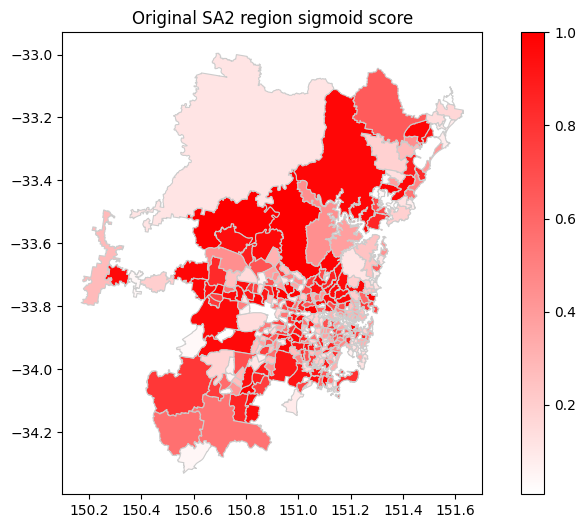

In [39]:
original_result = gpd.read_postgis(sql, con=conn, geom_col='geom')


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap where red signifies > 1 and white signifies 0
colors = [(1, 1, 1), (1, 0, 0)]  # White to Red
cmap_name = 'custom_red_white'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

original_result.plot(column='s_score', cmap=custom_cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Original SA2 region sigmoid score')
plt.show()


In [40]:
# drop all intermediate tables
'''
sql = """
DROP TABLE IF EXISTS sydney.region_stop_counts;
DROP TABLE IF EXISTS sydney.region_polling_counts;
DROP TABLE IF EXISTS sydney.region_primary_school_counts;
DROP TABLE IF EXISTS sydney.region_businesses_counts;
DROP TABLE IF EXISTS sydney.region_population_counts;
"""
query(conn, sql)
'''
# close connection

'\nsql = """\nDROP TABLE IF EXISTS sydney.region_stop_counts;\nDROP TABLE IF EXISTS sydney.region_polling_counts;\nDROP TABLE IF EXISTS sydney.region_primary_school_counts;\nDROP TABLE IF EXISTS sydney.region_businesses_counts;\nDROP TABLE IF EXISTS sydney.region_population_counts;\n"""\nquery(conn, sql)\n'

# Extra dataset 1: Walk count site
This dataset records the location of walk counting sites in Sydney. Regions with more people walking are more 'bustling' 
- Walking count sites are named `points_gdf` as it is a point Geopandas DataFrame
- SA2 regions are named `multipolygon_gdf` as it can be converted into multipolygons. 

In [41]:
import geopandas as gpd
points_gdf = gpd.read_file('Walking_count_sites.geojson')
multipolygon_gdf = gpd.read_file('SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')

Then we remove possibly `NULL` items.

In [42]:
# Remove possibly NULL items
multipolygon_gdf = multipolygon_gdf[multipolygon_gdf['GCC_CODE21'] == "1GSYD"]
points_gdf = points_gdf.dropna(subset=["OBJECTID"])
points_gdf

,OBJECTID,Site_ID,Location,SiteDescription,geometry
0,1,2,Botany Road,Between Bourke Street and Hansard Street,POINT (151.20287 -33.90732)
1,2,3,King Street,Between Whitehorse Street and Newman Street,POINT (151.17795 -33.89934)
2,3,4,William Street,Between Crown Street and Palmer Street,POINT (151.21666 -33.87438)
3,4,5,City Road,Between Carillon Avenue and Forbes Street,POINT (151.18803 -33.89170)
4,5,6,Broadway,Between Buckland Street and Abercrombie Street,POINT (151.19771 -33.88434)
...,...,...,...,...,...
115,116,118,Bridge Street,Between Loftus Street and Pitt Street,POINT (151.20968 -33.86356)
116,117,119,Margaret Street,Between George Street and Carrington Street,POINT (151.20689 -33.86512)
117,118,120,Margaret Street,Between Clarence Street and Kent Street,POINT (151.20452 -33.86516)
118,119,121,York Street,Between Barrack Street and King Street,POINT (151.20595 -33.86805)


No empty rows. This dataset is quite clean.

Next, we group the counting objects by SA2 regions. Note that we have to make sure they are of the same SRID before `sjoin`.

(If they have different SRIDs, the result will be useless and there will be a warning message)

We make those without any count 0 and then drop some unused columns.

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt

#Convert polygons into multi polygons
# Read your data containing points and MultiPolygon geometries
points_gdf = gpd.read_file('Walking_count_sites.geojson')
multipolygon_gdf = gpd.read_file('SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')

multipolygon_gdf = multipolygon_gdf[multipolygon_gdf['GCC_CODE21'] == "1GSYD"]

#4283
# if multipolygon_gdf.crs != points_gdf.crs:
multipolygon_gdf = multipolygon_gdf.to_crs("EPSG:4283")
points_gdf = points_gdf.to_crs("EPSG:4283")
print(multipolygon_gdf.crs)
print(points_gdf.crs)

# Perform a spatial join between the points and the MultiPolygon
points_within_multipolygon = gpd.sjoin(points_gdf, multipolygon_gdf, how="left", predicate='within')

# Group the points by polygon and count the number of points within each polygon
points_within_multipolygon_count = points_within_multipolygon.groupby('index_right').size()

# Optionally, merge the counts with the MultiPolygon GeoDataFrame
multipolygon_gdf = multipolygon_gdf.merge(points_within_multipolygon_count.rename('count'), how='left', left_index=True, right_index=True)
multipolygon_gdf['count'] = multipolygon_gdf['count'].fillna(0).astype(int)

multipolygon_gdf = multipolygon_gdf.drop(columns=['CHG_FLAG21', 'CHG_LBL21', 'GCC_CODE21', 'GCC_NAME21', 'AUS_CODE21','AUS_NAME21', 'STE_CODE21', 'STE_NAME21', 'LOCI_URI21', 'SA4_CODE21', 'SA3_CODE21', 'SA3_NAME21', 'SA4_NAME21', 'AREASQKM21'])
multipolygon_gdf


EPSG:4283
EPSG:4283


,SA2_CODE21,SA2_NAME21,geometry,count
28,102011028,Avoca Beach - Copacabana,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",0
29,102011029,Box Head - MacMasters Beach,"POLYGON ((151.37484 -33.50053, 151.37506 -33.5...",0
30,102011030,Calga - Kulnura,"MULTIPOLYGON (((151.20448 -33.53281, 151.20447...",0
31,102011031,Erina - Green Point,"POLYGON ((151.37193 -33.43699, 151.37288 -33.4...",0
32,102011032,Gosford - Springfield,"POLYGON ((151.32348 -33.42780, 151.32342 -33.4...",0
...,...,...,...,...
637,128021537,Royal National Park,"POLYGON ((151.07362 -34.05639, 151.07360 -34.0...",0
638,128021538,Sutherland - Kirrawee,"POLYGON ((151.05006 -34.02159, 151.05007 -34.0...",0
639,128021607,Engadine,"POLYGON ((150.99568 -34.05362, 150.99569 -34.0...",0
640,128021608,Loftus - Yarrawarrah,"POLYGON ((151.03954 -34.04176, 151.03954 -34.0...",0


Converting polygons into multipolygons, then WKT.

Now try visualizing this: 

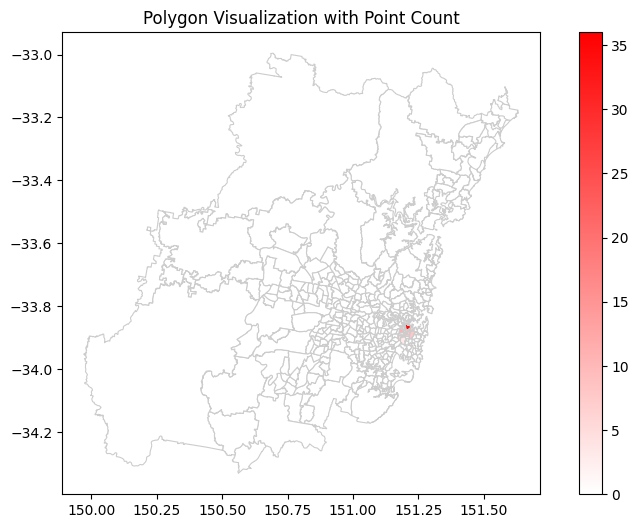

In [44]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# Define a custom colormap where red signifies > 1 and white signifies 0
colors = [(1, 1, 1), (1, 0, 0)]  # White to Red， RGB 
cmap_name = 'custom_red_white'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Plot the MultiPolygon GeoDataFrame with the custom colormap
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the MultiPolygon GeoDataFrame with the 'count' column
multipolygon_gdf.plot(column='count', cmap=custom_cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Polygon Visualization with Point Count')
plt.show()


We can see the counting objects are mainly in core areas of Sydney, which makes sense

In [45]:
multipolygon_gdf['geom'] = multipolygon_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4283)) 
multipolygon_gdf.columns = map(str.lower, multipolygon_gdf.columns)
multipolygon_gdf.head(1)
# multipolygon_gdf['geom'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) 

,sa2_code21,sa2_name21,geometry,count,geom
28,102011028,Avoca Beach - Copacabana,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",0,MULTIPOLYGON (((151.4137275699985 -33.46559324...


In [46]:
try:
    multipolygon_gdf = multipolygon_gdf.drop(columns=['geometry'])
except:
    pass
multipolygon_gdf['sa2_code21'] = multipolygon_gdf['sa2_code21'].astype(int)
multipolygon_gdf
multipolygon_gdf.head(373)


,sa2_code21,sa2_name21,count,geom
28,102011028,Avoca Beach - Copacabana,0,MULTIPOLYGON (((151.4137275699985 -33.46559324...
29,102011029,Box Head - MacMasters Beach,0,MULTIPOLYGON (((151.3748353599985 -33.50053262...
30,102011030,Calga - Kulnura,0,MULTIPOLYGON (((151.20448489999853 -33.5328149...
31,102011031,Erina - Green Point,0,MULTIPOLYGON (((151.37193064999855 -33.4369917...
32,102011032,Gosford - Springfield,0,MULTIPOLYGON (((151.32348091999853 -33.4277979...
...,...,...,...,...
637,128021537,Royal National Park,0,MULTIPOLYGON (((151.07362454999853 -34.0563916...
638,128021538,Sutherland - Kirrawee,0,MULTIPOLYGON (((151.05005897999854 -34.0215901...
639,128021607,Engadine,0,MULTIPOLYGON (((150.99567802999852 -34.0536209...
640,128021608,Loftus - Yarrawarrah,0,MULTIPOLYGON (((151.03954277999853 -34.0417579...


In [47]:
points_gdf = gpd.read_file('Walking_count_sites.geojson')
points_gdf.columns = map(str.lower, points_gdf.columns)
points_gdf



,objectid,site_id,location,sitedescription,geometry
0,1,2,Botany Road,Between Bourke Street and Hansard Street,POINT (151.20287 -33.90732)
1,2,3,King Street,Between Whitehorse Street and Newman Street,POINT (151.17795 -33.89934)
2,3,4,William Street,Between Crown Street and Palmer Street,POINT (151.21666 -33.87438)
3,4,5,City Road,Between Carillon Avenue and Forbes Street,POINT (151.18803 -33.89170)
4,5,6,Broadway,Between Buckland Street and Abercrombie Street,POINT (151.19771 -33.88434)
...,...,...,...,...,...
115,116,118,Bridge Street,Between Loftus Street and Pitt Street,POINT (151.20968 -33.86356)
116,117,119,Margaret Street,Between George Street and Carrington Street,POINT (151.20689 -33.86512)
117,118,120,Margaret Street,Between Clarence Street and Kent Street,POINT (151.20452 -33.86516)
118,119,121,York Street,Between Barrack Street and King Street,POINT (151.20595 -33.86805)


In [48]:
points_gdf = points_gdf.rename(columns={'sitedescription': 'description'})
points_gdf = points_gdf.drop(columns=['site_id'])


In [49]:

points_gdf['geom'] = points_gdf['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))

points_gdf['geom'] = points_gdf['geom'].apply(lambda x: str(x))

points_gdf = points_gdf.drop(columns=['geometry'])

points_gdf.dtypes


objectid        int64
location       object
description    object
geom           object
dtype: object

Create schema and load walking dataframe into SQL

In [50]:
conn.execute(text("""
DROP TABLE IF EXISTS sydney.points_gdf;
CREATE TABLE sydney.points_gdf (
    objectid INTEGER,
    location VARCHAR(100),
    description VARCHAR(100),
    geom GEOMETRY(POINT, 4283)
    );
"""))

# points_gdf.to_sql("objects", con=conn, schema="sydney", if_exists='append', index=False)
points_gdf.to_sql("points_gdf", con=conn, schema="sydney", if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
sql = """
SELECT * FROM points_gdf
"""
query(conn, sql)

,objectid,location,description,geom
0,1,Botany Road,Between Bourke Street and Hansard Street,0101000020BB1000006C7BD6E07DE662407090952023F4...
1,2,King Street,Between Whitehorse Street and Newman Street,0101000020BB100000CCFB4BBEB1E56240000D09881DF3...
2,3,William Street,Between Crown Street and Palmer Street,0101000020BB10000007620FE4EEE66240D26CBF88EBEF...
3,4,City Road,Between Carillon Avenue and Forbes Street,0101000020BB100000AC39D55204E66240D7AFA81F23F2...
4,5,Broadway,Between Buckland Street and Abercrombie Street,0101000020BB1000009A13F3A553E662403413AD1B32F1...
...,...,...,...,...
115,116,Bridge Street,Between Loftus Street and Pitt Street,0101000020BB100000C64FBFB0B5E6624046D9C94989EE...
116,117,Margaret Street,Between George Street and Carrington Street,0101000020BB100000BCADAEDB9EE6624076941D3CBCEE...
117,118,Margaret Street,Between Clarence Street and Kent Street,0101000020BB100000BBC830728BE6624092575E97BDEE...
118,119,York Street,Between Barrack Street and King Street,0101000020BB1000003D1B1E2C97E6624022F6695B1CEF...


Create a new table, join SA2 code with the data we just imported

In [51]:
sql = """
DROP TABLE IF EXISTS sydney.region_points_gdf_counts;
CREATE TABLE IF NOT EXISTS sydney.region_points_gdf_counts AS
    SELECT
        r.sa2_code21,
        COUNT(s.objectid) AS number_of_object
    FROM
        sydney.sa2_regions AS r
    LEFT JOIN
        sydney.points_gdf AS s
    ON
        ST_Contains(r.geom, s.geom)
    GROUP BY
        r.sa2_code21
"""
query(conn, sql)

sql = """
SELECT * FROM region_points_gdf_counts
ORDER BY number_of_object DESC
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code21,number_of_object
0,117031644,36
1,117031331,11
2,117031329,10
3,117031642,9
4,118011345,8
...,...,...
368,102011039,0
369,102011040,0
370,102011041,0
371,102011042,0


# Extra dataset 2: buildings

This dataset is about dwelling approvals. More buildings will mean more people to 'bustle' in the future

In [52]:
import pandas as pd 
buildings = pd.read_csv('Copy of NSW, SA2 excel data cube, 2023-2024 FYTD.csv')

column_mapping = {
    'New houses': 'New_houses',
    'New other residential building': 'New_other_residential_building',
    'Total dwellings': 'Total_dwellings',
    'Value of new houses': 'Value_of_new_houses',
    'Value of new other residential building': 'Value_of_new_other_residential_building',
    'Value of total residential building': 'Value_of_total_residential_building',
    'Value of non-residential building': 'Value_of_non_residential_building',
    'Value of total building': 'Value_of_total_building'
}
buildings.rename(columns=column_mapping, inplace=True)

# Check for missing values in the 'sa2_code' column, as this is the primary key
missing_sa2_code = buildings['sa2_code'].isnull()
print (f"{buildings['sa2_code'].isnull().sum()} rows with empty primary key have been deleted")
buildings = buildings[~missing_sa2_code]

#lower case columns names
buildings.columns = map(str.lower, buildings.columns)

#delete unnamed or unwanted columns
buildings = buildings[[col for col in buildings.columns if not col.startswith('unnamed')]]
buildings = buildings.drop(columns='value of alterations & additions including conversions to residential building')

# Filter the DataFrame to keep only rows where 'sa2_code' has exactly 9 characters
buildings = buildings[buildings['sa2_code'].apply(len) == 9]

# Convert columns to integer using to_numeric(), safe conversion with errors='coerce'
columns_to_convert = [
    'sa2_code', 'new_houses', 'new_other_residential_building', 'total_dwellings',
    'value_of_new_houses', 'value_of_new_other_residential_building',
    'value_of_total_residential_building', 'value_of_non_residential_building',
    'value_of_total_building'
]

for column in columns_to_convert:
    buildings[column] = pd.to_numeric(buildings[column].str.replace(',', ''), errors='coerce').fillna(0).astype(float)

buildings['sa2_code'] = buildings['sa2_code'].astype(int)
#TODO
buildings.rename(columns={
    'sa2_name': 'sa2_name21'
}, inplace=True)
buildings


3 rows with empty primary key have been deleted


,sa2_code,sa2_name21,new_houses,new_other_residential_building,total_dwellings,value_of_new_houses,value_of_new_other_residential_building,value_of_total_residential_building,value_of_non_residential_building,value_of_total_building
4,102011028,Avoca Beach - Copacabana,16.0,2.0,18.0,13101.0,724.0,23110.0,650.0,23760.0
5,102011029,Box Head - MacMasters Beach,18.0,1.0,19.0,12083.0,571.0,24466.0,336.0,24802.0
6,102011030,Calga - Kulnura,4.0,0.0,4.0,3837.0,0.0,6956.0,26326.0,33282.0
7,102011031,Erina - Green Point,9.0,42.0,51.0,7281.0,23987.0,34585.0,35290.0,69875.0
8,102011032,Gosford - Springfield,12.0,56.0,68.0,4954.0,22711.0,30615.0,80088.0,110703.0
...,...,...,...,...,...,...,...,...,...,...
761,114021286,Mittagong,31.0,9.0,41.0,16240.0,2590.0,24579.0,13257.0,37836.0
762,114021287,Moss Vale - Berrima,23.0,5.0,28.0,13339.0,1692.0,17490.0,33729.0,51219.0
763,114021288,Robertson - Fitzroy Falls,7.0,0.0,7.0,20950.0,0.0,26199.0,573.0,26772.0
764,114021289,Southern Highlands,44.0,4.0,49.0,29938.0,1243.0,40130.0,3433.0,43564.0


Create schema and load buildings dataframe into SQL

In [53]:
conn.execute(text("""
DROP TABLE IF EXISTS sydney.buildings;
CREATE TABLE sydney.buildings (
    sa2_code INTEGER,
    sa2_name21 VARCHAR(100),
    new_houses NUMERIC,
    new_other_residential_building INTEGER,
    total_dwellings INTEGER,
    value_of_new_houses NUMERIC,
    value_of_new_other_residential_building NUMERIC,
    value_of_total_residential_building NUMERIC,
    value_of_non_residential_building NUMERIC,
    value_of_total_building NUMERIC
);
"""))

buildings.to_sql("buildings", con=conn, schema="sydney", if_exists='append', index=False)

sql = """
SELECT * FROM buildings
"""
query(conn, sql)

,sa2_code,sa2_name21,new_houses,new_other_residential_building,total_dwellings,value_of_new_houses,value_of_new_other_residential_building,value_of_total_residential_building,value_of_non_residential_building,value_of_total_building
0,102011028,Avoca Beach - Copacabana,16.0,2,18,13101.0,724.0,23110.0,650.0,23760.0
1,102011029,Box Head - MacMasters Beach,18.0,1,19,12083.0,571.0,24466.0,336.0,24802.0
2,102011030,Calga - Kulnura,4.0,0,4,3837.0,0.0,6956.0,26326.0,33282.0
3,102011031,Erina - Green Point,9.0,42,51,7281.0,23987.0,34585.0,35290.0,69875.0
4,102011032,Gosford - Springfield,12.0,56,68,4954.0,22711.0,30615.0,80088.0,110703.0
...,...,...,...,...,...,...,...,...,...,...
638,114021286,Mittagong,31.0,9,41,16240.0,2590.0,24579.0,13257.0,37836.0
639,114021287,Moss Vale - Berrima,23.0,5,28,13339.0,1692.0,17490.0,33729.0,51219.0
640,114021288,Robertson - Fitzroy Falls,7.0,0,7,20950.0,0.0,26199.0,573.0,26772.0
641,114021289,Southern Highlands,44.0,4,49,29938.0,1243.0,40130.0,3433.0,43564.0


## Calculate S score with extra datasets

In [54]:
sql = """
DROP TABLE IF EXISTS sydney.sa2_aggregated_data;
CREATE TABLE sydney.sa2_aggregated_data AS
SELECT
    pc.sa2_code,
    pc.sa2_name21,
    COALESCE(bc.total_retail_businesses, 0) AS total_retail_businesses,
    COALESCE(sc.number_of_primary_schools, 0) AS number_of_primary_schools,
    COALESCE(pc2.number_of_pollings, 0) AS number_of_pollings,
    COALESCE(sc2.number_of_stops, 0) AS number_of_stops,
    b.value_of_total_building,
    COALESCE(gdf.number_of_object, 0) AS number_of_object,
    pc.geom
FROM
    sydney.region_population_counts pc
LEFT JOIN
    sydney.region_businesses_counts bc ON pc.sa2_code = bc.sa2_code
LEFT JOIN
    sydney.region_primary_school_counts sc ON pc.sa2_code = CAST(sc.sa2_code21 AS INTEGER)
LEFT JOIN
    sydney.region_polling_counts pc2 ON pc.sa2_code = CAST(pc2.sa2_code21 AS INTEGER)
LEFT JOIN
    sydney.region_stop_counts sc2 ON pc.sa2_code = CAST(sc2.sa2_code21 AS INTEGER)
LEFT JOIN
    sydney.buildings b ON pc.sa2_code = b.sa2_code
LEFT JOIN
    sydney.region_points_gdf_counts gdf ON pc.sa2_code = CAST(gdf.sa2_code21 AS INTEGER)
WHERE
    pc.total_population_0_19 >= 100
"""
query(conn, sql)

sql = """
SELECT * FROM sa2_aggregated_data
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name21,total_retail_businesses,number_of_primary_schools,number_of_pollings,number_of_stops,value_of_total_building,number_of_object,geom
0,102011028,Avoca Beach - Copacabana,45,4,2,127,23760.0,0,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,50,4,2,215,24802.0,0,0106000020BB1000000100000001030000000100000010...
2,102011030,Calga - Kulnura,57,17,7,172,33282.0,0,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,152,10,6,285,69875.0,0,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,180,10,7,355,110703.0,0,0106000020BB100000010000000103000000010000007E...
...,...,...,...,...,...,...,...,...,...
354,128021536,Oyster Bay - Como - Jannali,95,9,7,254,33086.0,0,0106000020BB10000001000000010300000001000000EF...
355,128021538,Sutherland - Kirrawee,124,12,6,195,53354.0,0,0106000020BB1000000100000001030000000100000089...
356,128021607,Engadine,68,7,7,221,33479.0,0,0106000020BB100000010000000103000000010000008E...
357,128021608,Loftus - Yarrawarrah,29,6,2,144,7548.0,0,0106000020BB10000001000000010300000001000000A1...


In [55]:
sql = """
DROP TABLE IF EXISTS sydney.sa2_s_scores;
CREATE TABLE sydney.sa2_s_scores AS
    SELECT
        sa2_code,
        sa2_name21,
        
        -- Calculate the sigmoid function for the sum of z-scores
        1 / (1 + EXP(-(
            z_score_total_retail_businesses +
            z_score_number_of_primary_schools +
            z_score_number_of_pollings +
            z_score_number_of_stops +
            z_score_value_of_total_building +
            z_score_number_of_object
        ))) AS s_score,
        
        geom

    FROM (
        SELECT
            sa2_code,
            sa2_name21,
            total_retail_businesses,
            number_of_primary_schools,
            number_of_pollings,
            number_of_stops,
            
            -- Calculating Z-score for total_retail_businesses
            (total_retail_businesses - AVG(total_retail_businesses) OVER()) / STDDEV(total_retail_businesses) OVER() AS z_score_total_retail_businesses,
            
            -- Calculating Z-score for number_of_primary_schools
            (number_of_primary_schools - AVG(number_of_primary_schools) OVER()) / STDDEV(number_of_primary_schools) OVER() AS z_score_number_of_primary_schools,
            
            -- Calculating Z-score for number_of_pollings
            (number_of_pollings - AVG(number_of_pollings) OVER()) / STDDEV(number_of_pollings) OVER() AS z_score_number_of_pollings,
            
            -- Calculating Z-score for number_of_stops
            (number_of_stops - AVG(number_of_stops) OVER()) / STDDEV(number_of_stops) OVER() AS z_score_number_of_stops,

            -- Calculating Z-score for value_of_total_building
            (value_of_total_building - AVG(value_of_total_building) OVER()) / STDDEV(value_of_total_building) OVER() AS z_score_value_of_total_building,
            
            -- Calculating Z-score for number_of_object
            (number_of_object - AVG(number_of_object) OVER()) / STDDEV(number_of_object) OVER() AS z_score_number_of_object,

            geom
            
        FROM sydney.sa2_aggregated_data
    ) AS z_scores;

"""
query(conn, sql)

sql = """
SELECT
    s.sa2_code,
    s.sa2_name21,
    s.s_score,
    i.median_income,
    s.geom
FROM
    sa2_s_scores s
JOIN
    income i on s.sa2_code = i.sa2_code21
order by s.s_score DESC
"""
sa2_s_scores = pd.DataFrame(query(conn, sql))
sa2_s_scores

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name21,s_score,median_income,geom
0,117031644,Sydney (North) - Millers Point,1.000000,62966,0106000020BB100000030000000103000000010000000E...
1,117031645,Sydney (South) - Haymarket,1.000000,35875,0106000020BB10000001000000010300000001000000B1...
2,115021297,Dural - Kenthurst - Wisemans Ferry,0.999999,58477,0106000020BB100000010000000103000000010000009C...
3,127011505,Austral - Greendale,0.999493,54758,0106000020BB10000001000000010300000001000000F9...
4,115031300,Kurrajong Heights - Ebenezer,0.998970,58312,0106000020BB10000001000000010300000001000000D7...
...,...,...,...,...,...
354,126021590,Putney,0.007201,67729,0106000020BB10000001000000010300000001000000A3...
355,102021052,Summerland Point - Gwandalan,0.006541,51708,0106000020BB1000000100000001030000000100000054...
356,118021654,South Coogee,0.005212,71138,0106000020BB10000001000000010300000001000000C4...
357,116021562,Acacia Gardens,0.004357,65756,0106000020BB100000010000000103000000010000005B...


In [56]:
sql = """
SELECT
    s.sa2_code,
    s.sa2_name21,
    s.s_score,
    i.median_income,
    s.geom
FROM
    sa2_s_scores s
JOIN
    income i on s.sa2_code = i.sa2_code21
order by s.s_score DESC
"""
sa2_s_scores = gpd.read_postgis(sql, con=conn, geom_col='geom')
sa2_s_scores

,sa2_code,sa2_name21,s_score,median_income,geom
0,117031644,Sydney (North) - Millers Point,1.000000,62966,"MULTIPOLYGON (((151.22538 -33.85525, 151.22525..."
1,117031645,Sydney (South) - Haymarket,1.000000,35875,"MULTIPOLYGON (((151.19852 -33.87579, 151.19847..."
2,115021297,Dural - Kenthurst - Wisemans Ferry,0.999999,58477,"MULTIPOLYGON (((150.93444 -33.65020, 150.93451..."
3,127011505,Austral - Greendale,0.999493,54758,"MULTIPOLYGON (((150.71009 -33.91665, 150.71012..."
4,115031300,Kurrajong Heights - Ebenezer,0.998970,58312,"MULTIPOLYGON (((150.61982 -33.52875, 150.61986..."
...,...,...,...,...,...
354,126021590,Putney,0.007201,67729,"MULTIPOLYGON (((151.09996 -33.82540, 151.09996..."
355,102021052,Summerland Point - Gwandalan,0.006541,51708,"MULTIPOLYGON (((151.55618 -33.13680, 151.55601..."
356,118021654,South Coogee,0.005212,71138,"MULTIPOLYGON (((151.25113 -33.93111, 151.25109..."
357,116021562,Acacia Gardens,0.004357,65756,"MULTIPOLYGON (((150.91593 -33.72971, 150.91661..."


## Histogram 
For an overall view of our result, we produce a histogram

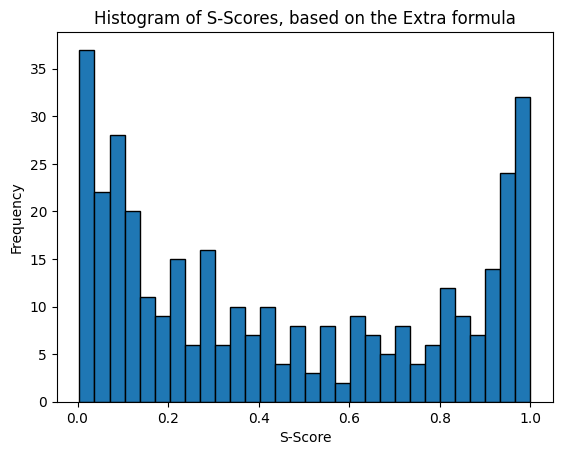

In [60]:
# Plot histogram of s_score
sa2_s_scores['s_score'].plot.hist(bins=30, edgecolor='black')

# Add titles and labels
plt.title('Histogram of S-Scores, based on the Extra formula')
plt.xlabel('S-Score')
plt.ylabel('Frequency')

plt.show()


## Visualisation
We use a map of Sydney to demonstrate overall activity levels, as higher scores are red and lower scores are white

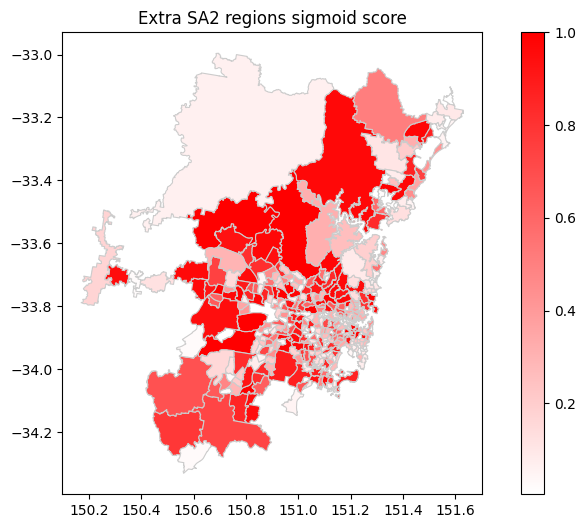

In [61]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap where red signifies > 1 and white signifies 0
colors = [(1, 1, 1), (1, 0, 0)]  # White to Red
cmap_name = 'custom_red_white'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sa2_s_scores.plot(column='s_score', cmap=custom_cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Extra SA2 regions sigmoid score')
plt.show()


## Correlation analysis

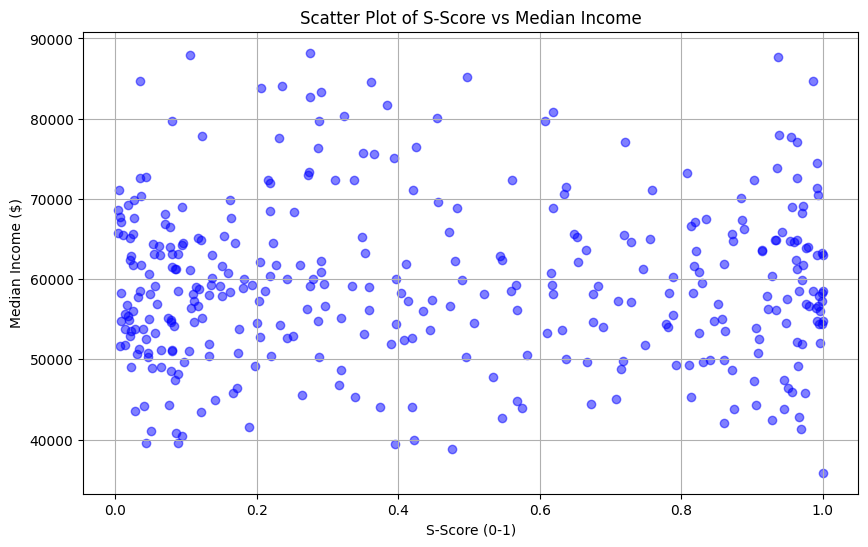

Pearson Correlation Coefficient between s_score and median_income: -0.0006037019588479899


In [ ]:
sa2_s_scores['median_income'] = sa2_s_scores['median_income'].astype(int)
sa2_s_scores['s_score'] = sa2_s_scores['s_score'].astype(float)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sa2_s_scores['s_score'], sa2_s_scores['median_income'], color='blue', alpha=0.5)
plt.title('Scatter Plot of S-Score vs Median Income')
plt.xlabel('S-Score (0-1)')
plt.ylabel('Median Income ($)')
plt.grid(True)

plt.show()

correlation = sa2_s_scores['s_score'].corr(sa2_s_scores['median_income'])
print("Pearson Correlation Coefficient between s_score and median_income:", correlation)

